In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/CECS551_Fianl_Project_Dataset/

/content/drive/My Drive/CECS551_Fianl_Project_Dataset


In [ ]:
import pandas as pd
import chardet
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

stores = pd.read_csv("CECS551_dataset_01/stores.csv")
test = pd.read_csv("CECS551_dataset_01/test.csv")
data = pd.read_csv("CECS551_dataset_01/train.csv")

train = data

store_01 = pd.read_csv("CECS551_dataset_01/store_features/store_01.xlsx")
store_02 = pd.read_excel("CECS551_dataset_01/store_features/store_02.xlsx")
store_03 = pd.read_excel("CECS551_dataset_01/store_features/store_03.xlsx")
store_04 = pd.read_excel("CECS551_dataset_01/store_features/store_04.xlsx")
store_05 = pd.read_excel("CECS551_dataset_01/store_features/store_05.xlsx")
store_06 = pd.read_excel("CECS551_dataset_01/store_features/store_06.xlsx")
store_07 = pd.read_excel("CECS551_dataset_01/store_features/store_07.xlsx")
store_08 = pd.read_excel("CECS551_dataset_01/store_features/store_08.xlsx")
store_09 = pd.read_excel("CECS551_dataset_01/store_features/store_09.xlsx")
store_10 = pd.read_excel("CECS551_dataset_01/store_features/store_10.xlsx")

store_11_35 = pd.read_excel("CECS551_dataset_01/store_features/store_11_35.xlsx")
ind_stores = [store_01,store_02,store_03,store_04,store_05,store_06,store_07,store_08,store_09,store_10]
features = pd.concat(ind_stores)


In [ ]:
data = pd.merge(data,stores,on='Store',how='left')
data['Date'] = pd.to_datetime(data['Date'])
features['Date'] = pd.to_datetime(features['Date'])

data = pd.merge(data,features,on=['Store','Date'],how='left')

data['Date'] = pd.to_datetime(data['Date'])
data.sort_values(by=['Date'],inplace=True)
data.set_index(data.Date, inplace=True)
data['IsHoliday_x'].isin(data['IsHoliday_y']).all()

store_11_to_35 = data.loc[data['Store'] > 10].copy()
data = store_11_to_35.loc[store_11_to_35['Store'] < 36].copy()


In [ ]:
def preProcessingData(data):
  data["CPI"].fillna(features["CPI"].median(),inplace=True)
  data["Unemployment"].fillna(features["Unemployment"].median(),inplace=True)
  data["discount_promotional"].fillna(value=0,inplace=True)
  data["discount_clearance"].fillna(value=0,inplace=True)
  data["discount_damaged_good"].fillna(value=0,inplace=True)
  data["discount_competitive"].fillna(value=0,inplace=True)
  data["Temperature"].fillna(features["Temperature"].median(),inplace=True)
  data["gas_price"].fillna(features["gas_price"].median(),inplace=True)
  data.isnull().sum()

  del data['gas_price']

  # After Merging IsHoliday value changes to IsHoliday, change it back to IsHoliday
  data.drop(columns='IsHoliday_y', axis=1,inplace=True)
  data.rename(columns={"IsHoliday_x" : "IsHoliday"}, inplace=True)
  data.isnull().sum()
  return data

data = preProcessingData(data)

In [ ]:
def splitData(data):
  # Split the date into days, month and year
  data['Year'] = data['Date'].dt.year
  data['Month'] = data['Date'].dt.month
  data['Week'] = data['Date'].dt.week

  # Calculate max, min, median and std deviation of first 10 store
  agg_data = data.groupby(['Store', 'Dept']).Weekly_Sales.agg(['max', 'min', 'mean', 'median', 'std']).reset_index()
  agg_data.isnull().sum()
  data.head(10)

  # Merge the above dataframe with the mainData frame
  store_data = pd.merge(left=data,right=agg_data,on=['Store', 'Dept'],how ='left')
  #store_data.dropna(inplace=True)
  data = store_data.copy()
  del store_data

  # Sort the dataframe by the date 
  data['Date'] = pd.to_datetime(data['Date'])
  data.sort_values(by=['Date'],inplace=True)
  data.set_index(data.Date, inplace=True)
  data.info()

  data['Total_discount'] = data['discount_promotional']+data['discount_clearance']+data['discount_damaged_good']+data['discount_competitive']
  data.drop(['discount_promotional','discount_clearance','discount_damaged_good','discount_competitive'], axis = 1,inplace=True)
  return data

data = splitData(data)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 242448 entries, 2010-02-05 to 2012-10-26
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Store                  242448 non-null  int64         
 1   Dept                   242448 non-null  int64         
 2   Date                   242448 non-null  datetime64[ns]
 3   Weekly_Sales           242448 non-null  float64       
 4   IsHoliday              242448 non-null  bool          
 5   Type                   242448 non-null  object        
 6   Size                   242448 non-null  int64         
 7   Temperature            242448 non-null  float64       
 8   discount_promotional   242448 non-null  float64       
 9   discount_clearance     242448 non-null  float64       
 10  discount_damaged_good  242448 non-null  float64       
 11  discount_competitive   242448 non-null  float64       
 12  CPI                    24244

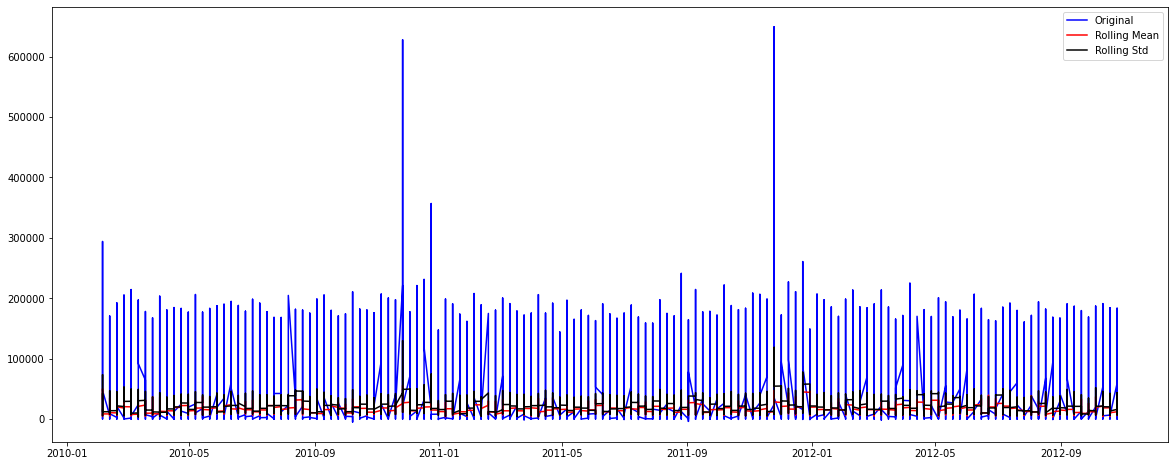

In [ ]:
def plot_timeseries_stat(timeseries):
    rollingMean = timeseries.rolling(window=30,center=False).mean()
    rollingStd = timeseries.rolling(window=30,center=False).std()
    plt.figure(figsize=(20,8))
    ori = plt.plot(timeseries,color='blue',label='Original')
    mean = plt.plot(rollingMean,color='red',label='Rolling Mean')
    std = plt.plot(rollingStd,color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.show(block=False)

sumData = data.groupby(['Store'], sort=False).agg({'Weekly_Sales': 'sum'})
sumData.head(25)

plot_timeseries_stat(data['Weekly_Sales'])

Test Statistic                 -42.41579
p-value                          0.00000
#Lags Used                      80.00000
No of Observesations Used   242367.00000
Critical Value (1%)             -3.43038
Critical Value (5%)             -2.86155
Critical Value (10%)            -2.56678
dtype: float64


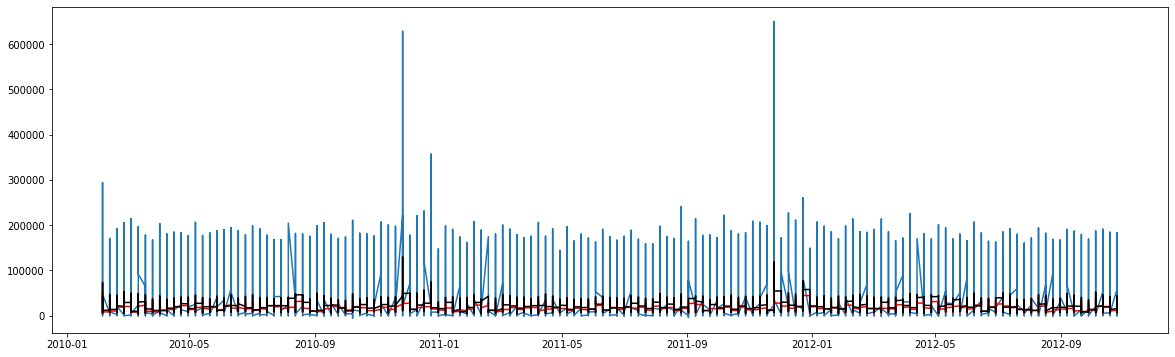

In [ ]:
#Making time series stationary
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math

def test_stationarityDF(timeseries): ##Dickey-Fuller Test
    dftest = adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','No of Observesations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

dataSeries = data['Weekly_Sales']
dataSeries.fillna(dataSeries.mean(),inplace=True)
test_stationarityDF(dataSeries)

movingAverage = dataSeries.rolling(window=30).mean()
movingSTD = dataSeries.rolling(window=30).std()
plt.figure(figsize=(20,6))
plt.plot(dataSeries)
plt.plot(movingAverage,color='red')
plt.plot(movingSTD,color='black')
plt.show()


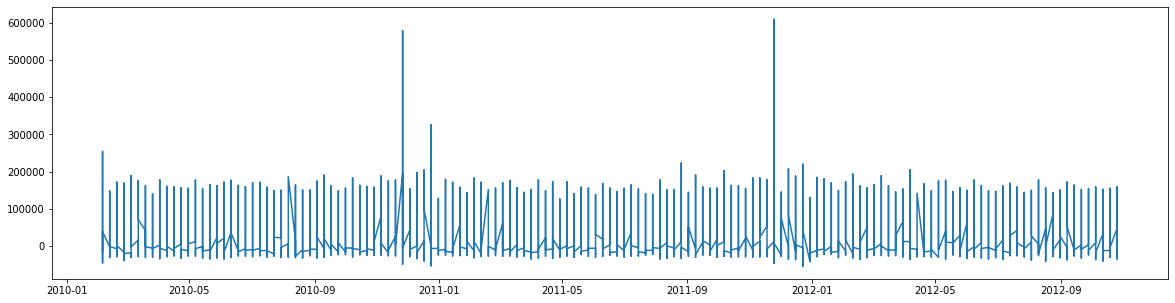

Test Statistic                 -80.85611
p-value                          0.00000
#Lags Used                      85.00000
No of Observesations Used   242362.00000
Critical Value (1%)             -3.43038
Critical Value (5%)             -2.86155
Critical Value (10%)            -2.56678
dtype: float64


In [ ]:
dataSeriesDiff = dataSeries-movingAverage
plt.figure(figsize=(20,5))
plt.plot(dataSeriesDiff)
plt.show()
pd.set_option('display.float_format', '{:.5f}'.format)
dataSeriesDiff.fillna(dataSeriesDiff.mean(),inplace=True)
test_stationarityDF(dataSeriesDiff)

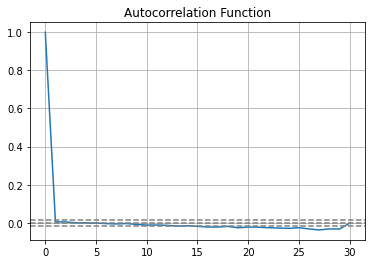

In [ ]:
plt.plot(np.arange(0,31,1),acf(dataSeriesDiff,nlags=30))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(dataSeriesDiff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(dataSeriesDiff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.grid()
plt.show()

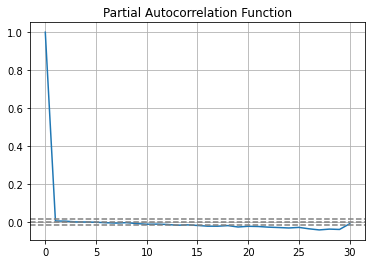

In [ ]:
plt.plot(np.arange(0,31,1),pacf(dataSeriesDiff,nlags=30))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(dataSeriesDiff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(dataSeriesDiff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.grid()
plt.show()

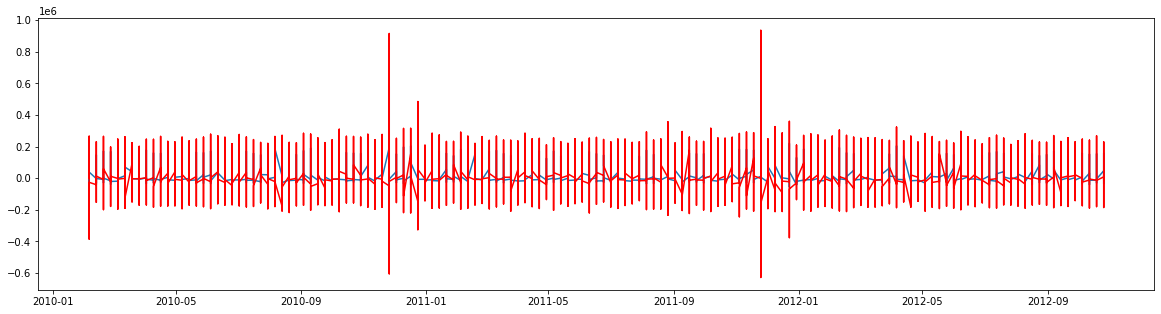

In [ ]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math

model = ARIMA(dataSeriesDiff,order=(2,2,0))
results_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(20,5))
plt.plot(dataSeriesDiff)
plt.plot(results_ARIMA.fittedvalues,color='red')
plt.show()

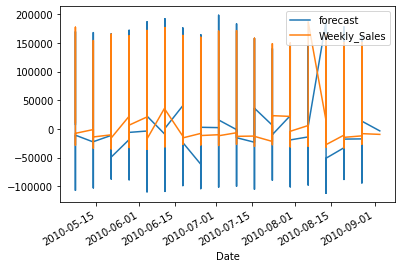

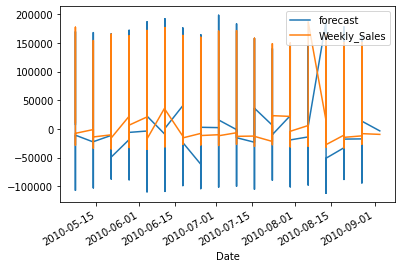

In [ ]:
results_ARIMA.plot_predict('2010-05','2010-9',dynamic=False)
